In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [203]:
import os

dim = (100, 100)
channels = 3

poster_data = []
posters_dir = 'posters/'
for f in os.listdir(posters_dir):
    if f.endswith(".jpg"):
        img_path = posters_dir + f
        img = image.load_img(img_path, target_size=dim, color_mode='rgb')
        x = image.img_to_array(img)
        poster_data.append(x)
poster_data = np.array(poster_data)

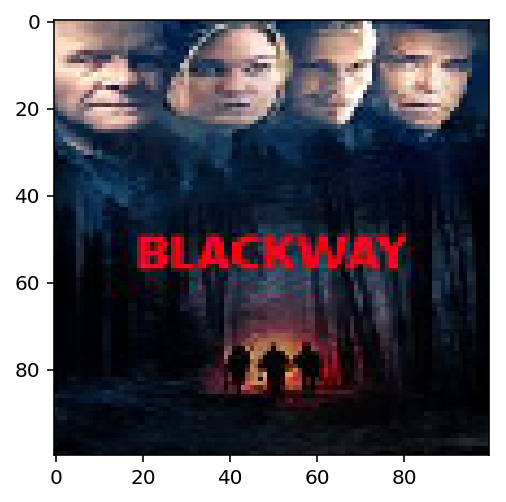

In [204]:
plt.imshow(poster_data[0]/255.)

In [205]:
train_data = poster_data[10:]
test_data = poster_data[0:10]


x_train = train_data.astype('float32') / 255.
x_test = test_data.astype('float32') / 255.

print len(train_data), len(test_data)

980 10


In [206]:
def get_encoder(input_img):
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
               input_shape=(dim[0], dim[1], channels))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

def get_decoded(encoded):
    # at this point the representation is (13, 13, 8)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same', input_shape=(dim[0], 
        dim[1], channels), data_format="channels_last")(x)
    return decoded

input_img = Input(shape=(dim[0], dim[1], channels))
encoded = get_encoder(input_img)
decoded = get_decoded(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_418 (Conv2D)          (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_419 (Conv2D)          (None, 50, 50, 16)        9232      
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_420 (Conv2D)          (None, 25, 25, 16)        2320      
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 13, 13, 16)        0         
__________

In [207]:
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_418 (Conv2D)          (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_419 (Conv2D)          (None, 50, 50, 16)        9232      
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_420 (Conv2D)          (None, 25, 25, 16)        2320      
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 13, 13, 16)        0         
Total para

In [208]:
num_encoder_layers = len(encoder.layers)
decoder_layers = len(autoencoder.layers)-num_encoder_layers

encoded_input = Input(shape=encoding_dim)
cur_layer = encoded_input
for l_num in range(decoder_layers):
    cur_layer = autoencoder.layers[num_encoder_layers+l_num](cur_layer)

decoder = Model(encoded_input, cur_layer)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_421 (Conv2D)          (None, 13, 13, 16)        2320      
_________________________________________________________________
up_sampling2d_199 (UpSamplin (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_422 (Conv2D)          (None, 26, 26, 16)        2320      
_________________________________________________________________
up_sampling2d_200 (UpSamplin (None, 52, 52, 16)        0         
_________________________________________________________________
conv2d_423 (Conv2D)          (None, 50, 50, 64)        9280      
_________________________________________________________________
up_sampling2d_201 (UpSamplin (None, 100, 100, 64)      0         
__________

In [210]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 980 samples, validate on 10 samples
Epoch 1/10
980/980 [==============================] - 35s 36ms/step - loss: 0.5336 - val_loss: 0.5236
Epoch 2/10
980/980 [==============================] - 32s 33ms/step - loss: 0.5264 - val_loss: 0.5237
Epoch 3/10
980/980 [==============================] - 30s 30ms/step - loss: 0.5191 - val_loss: 0.5392
Epoch 4/10
980/980 [==============================] - 29s 29ms/step - loss: 0.5172 - val_loss: 0.5286
Epoch 5/10
980/980 [==============================] - 28s 28ms/step - loss: 0.5128 - val_loss: 0.5209
Epoch 6/10
980/980 [==============================] - 28s 28ms/step - loss: 0.5085 - val_loss: 0.5049
Epoch 7/10
980/980 [==============================] - 28s 29ms/step - loss: 0.4986 - val_loss: 0.4919
Epoch 8/10
980/980 [==============================] - 28s 28ms/step - loss: 0.4974 - val_loss: 0.4927
Epoch 9/10
980/980 [==============================] - 28s 29ms/step - loss: 0.4917 - val_loss: 0.4901
Epoch 10/10
980/980 [================

In [211]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)


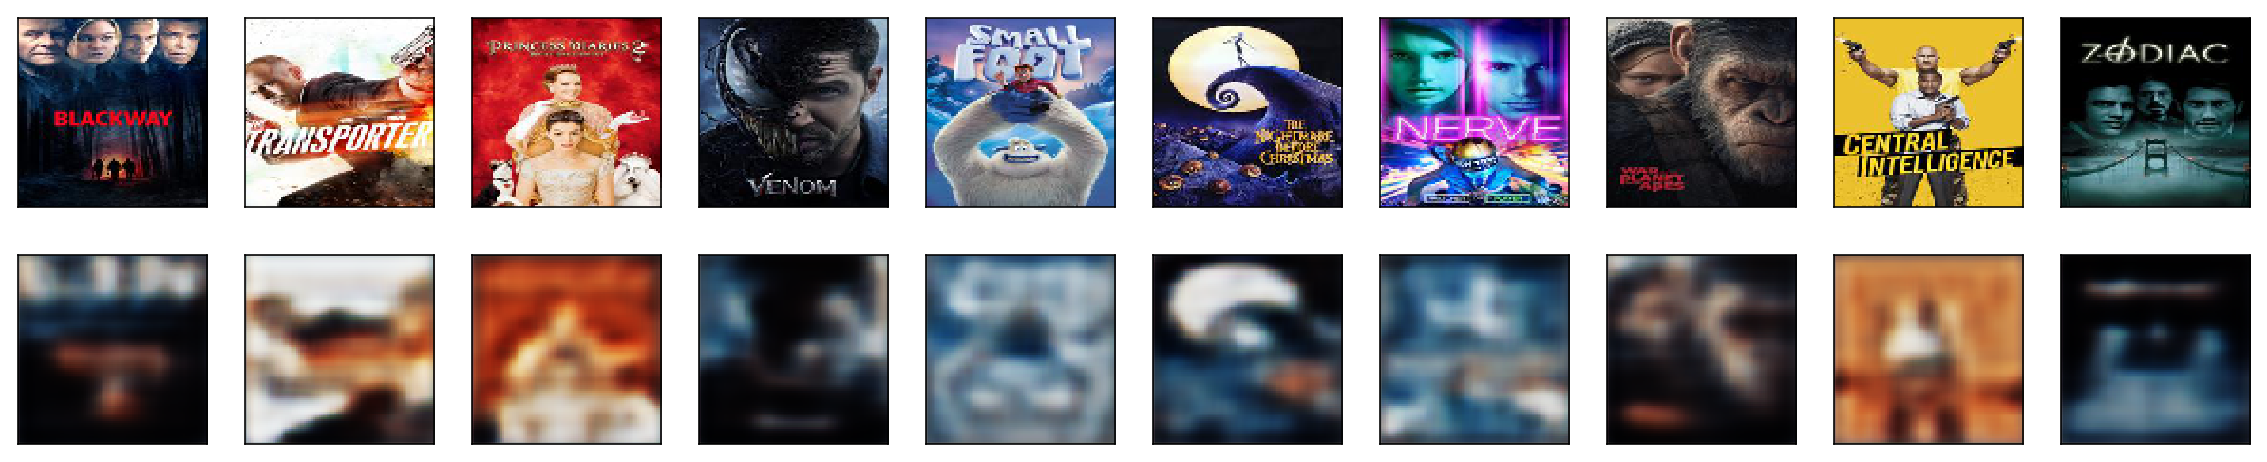

In [212]:

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


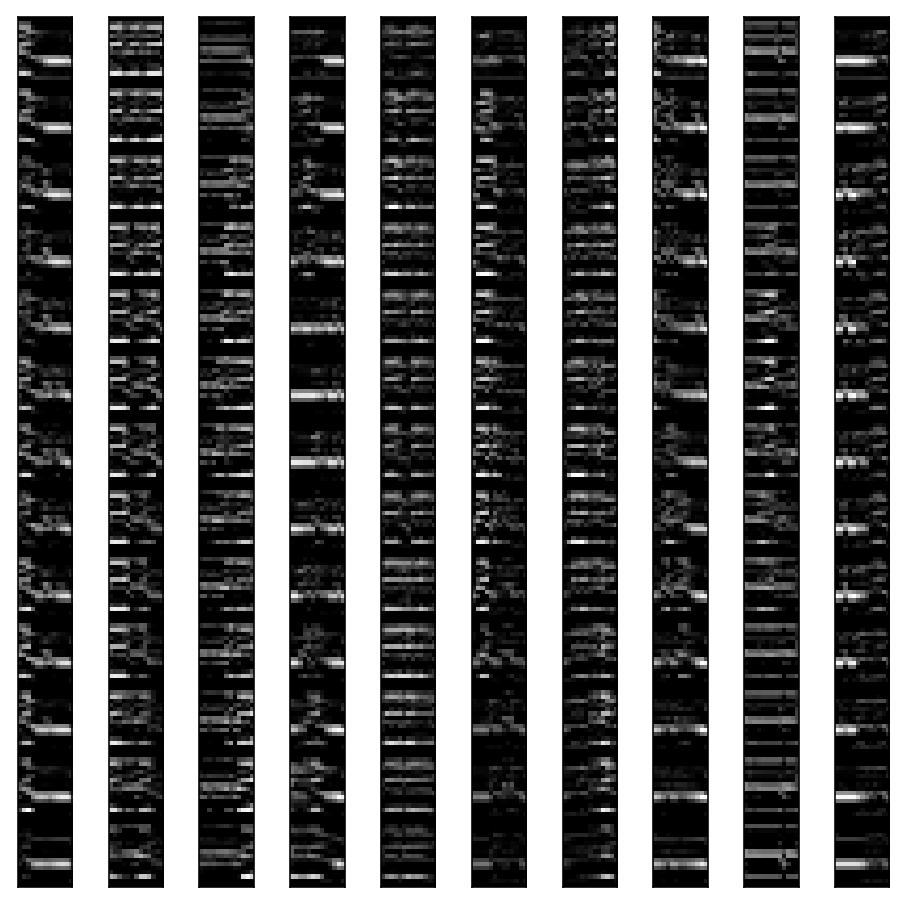

In [213]:
n = 10
plt.figure(figsize=(8, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(13, 13 * 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [214]:
mean_poster = np.mean(encoded_imgs, axis=0)
mean_poster = np.array([mean_poster])
mean_poster.shape

(1, 13, 13, 16)

(1, 100, 100, 3)

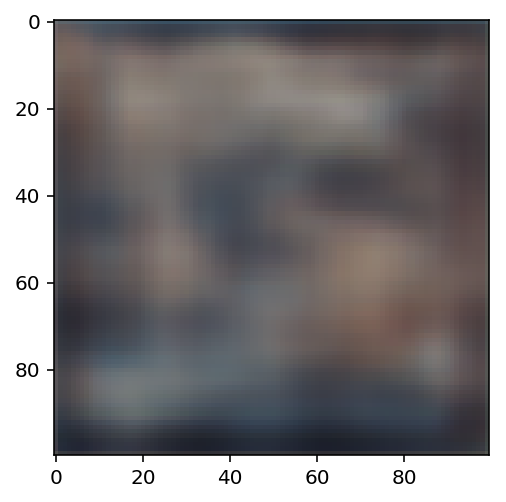

In [215]:
mean_poster_prediction = decoder.predict(mean_poster)
plt.imshow(mean_poster_prediction[0])
mean_poster_prediction.shape